In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and inspect datasets

zomato_df = pd.read_csv('zomato.csv')
locations_df = pd.read_csv('locations.csv')

print('Zomato DF:')
print('Shape:', zomato_df.shape)
print('Columns:', zomato_df.columns)
print('')
print('Locations DF:')
print('Shape:', locations_df.shape)
print('Columns:', locations_df.columns)

zomato_df.head(1)

Zomato DF:
Shape: (51717, 17)
Columns: Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

Locations DF:
Shape: (94, 2)
Columns: Index(['Name', 'geo_loc'], dtype='object')


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari


In [3]:
# Check Zomato DF datatypes

zomato_df.dtypes

url                            object
address                        object
name                           object
online_order                   object
book_table                     object
rate                           object
votes                           int64
phone                          object
location                       object
rest_type                      object
dish_liked                     object
cuisines                       object
approx_cost(for two people)    object
reviews_list                   object
menu_item                      object
listed_in(type)                object
listed_in(city)                object
dtype: object

Index(['dish_liked', 'rate', 'phone', 'approx_cost(for two people)',
       'rest_type', 'cuisines', 'location'],
      dtype='object')


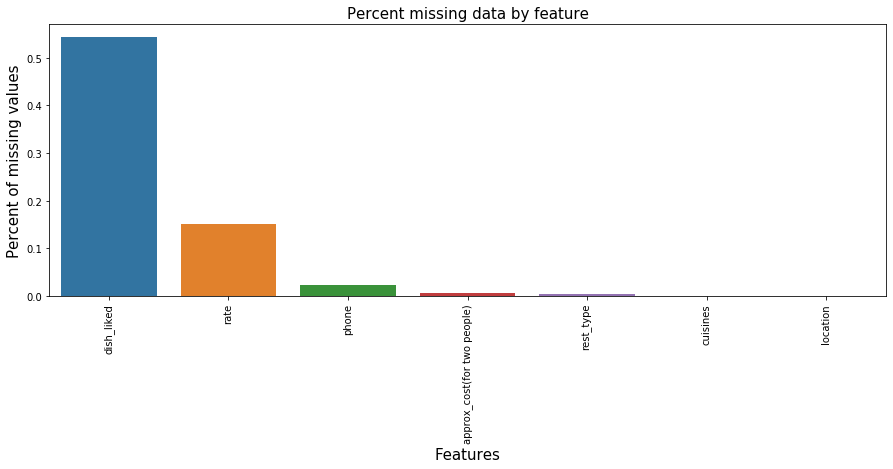

In [4]:
# Check for missing data

total = zomato_df.isnull().sum().sort_values(ascending=False)
percent = (zomato_df.isnull().sum()/zomato_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).head(7)

f, ax = plt.subplots(figsize=(15, 5))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

print(missing_data.index)

In [5]:
# Check for duplicates

zomato_df.duplicated().sum()

0

In [6]:
# Simplify column names

zomato_df = zomato_df.rename(columns={'approx_cost(for two people)':'cost', 
                                      'listed_in(type)':'type', 
                                      'listed_in(city)':'city'})

In [7]:
# Drop unecessary columns

drop = ['url', 'address', 'phone']

zomato_df = zomato_df.drop(drop, axis=1)

print(zomato_df.shape)
zomato_df.head(1)

(51717, 14)


,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari


In [8]:
# Clean rate column and turn it into type float

zomato_temp = zomato_df.copy()

zomato_temp['rate'].replace(('NEW','-'),np.nan,inplace =True) 
zomato_temp['rate'] = zomato_temp['rate'].astype('str').apply(lambda x: x.replace('/5','').strip()).astype('float')

print(zomato_temp['rate'].isnull().sum() / zomato_temp['rate'].isnull().count())

0.19436548910416304


In [9]:
# Replace missing rates with rates from reviews_list column

import ast

zomato_temp['reviews_list'] = zomato_temp['reviews_list'].apply(lambda x: ast.literal_eval(x))

def get_rate(x):
    '''
    extract the rate value out of a string inside tuple
    '''
    # ensure that x is not Null and there is more than one rate
    if not x or len(x) <= 1:
        return None
    rate = [float(i[0].replace('Rated','').strip())  for i in x if type(i[0])== str]
    return round((sum(rate)/len(rate)),1)

zomato_temp['review_rate']  = zomato_temp['reviews_list'].apply(lambda x : get_rate(x))

nan_index = zomato_temp.query('rate != rate & review_rate == review_rate').index
for i in nan_index:
    zomato_temp.loc[i,'rate'] = zomato_temp.loc[i,'review_rate'] 
    
print(zomato_temp['rate'].isnull().sum() / zomato_temp['rate'].isnull().count())

0.16516812653479512


In [10]:
# Turn cost into type float and fill missing values with the group mean, according to restaurant location and type

zomato_temp['cost'] = zomato_temp['cost'].fillna(0)
zomato_temp['cost'] = zomato_temp['cost'].astype(str).apply(lambda x: int(x.replace(',',''))).astype(float)
zomato_temp['cost'] = zomato_temp['cost'].replace(0, zomato_temp.groupby(['location', 'type'])['cost'].transform('median'))

In [11]:
# Drop unnecessary columns and check clean dataframe

zomato_temp = zomato_temp.drop(columns=['reviews_list', 'review_rate', 'menu_item'])

print(zomato_temp.shape)
zomato_temp.head()

(51717, 12)


,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,cost,type,city
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,Buffet,Banashankari
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,Buffet,Banashankari


In [12]:
# Check missing values

zomato_temp.isnull().sum() / len(zomato_temp)

name            0.000000
online_order    0.000000
book_table      0.000000
rate            0.165168
votes           0.000000
location        0.000406
rest_type       0.004389
dish_liked      0.542916
cuisines        0.000870
cost            0.000406
type            0.000000
city            0.000000
dtype: float64

In [13]:
# Isolate location name in locations dataframe

locations_df['location'] = locations_df['Name'].str.split(n=1).str[1]
locations_df.head()

,Name,geo_loc,location
0,Bangalore Banashankari,"(12.9152208, 77.573598)",Banashankari
1,Bangalore Basavanagudi,"(12.9417261, 77.5755021)",Basavanagudi
2,Bangalore Mysore Road,"(12.9314092, 77.5067138)",Mysore Road
3,Bangalore Jayanagar,"(12.9292731, 77.5824229)",Jayanagar
4,Bangalore Kumaraswamy Layout,"(12.9068169, 77.5635247362134)",Kumaraswamy Layout


In [14]:
# Merge geo locations from locations dataframe with zomato dataframe

zomato_temp = zomato_temp.merge(locations_df[['location','geo_loc']], on = ['location'], how = 'left')
print(zomato_temp.shape)
zomato_temp.head()

(51717, 13)


,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,cost,type,city,geo_loc
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,Buffet,Banashankari,"(12.9417261, 77.5755021)"


In [15]:
# Create clean dataset without missing values

zomato_clean = zomato_temp.drop(columns='dish_liked')
zomato_clean = zomato_clean.dropna()
print(zomato_clean.shape)
zomato_clean.head()

(42152, 12)


,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,type,city,geo_loc
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,Buffet,Banashankari,"(12.9417261, 77.5755021)"


In [16]:
# Split data according to column data type

cat_data = zomato_clean.select_dtypes(include='object')
float_data = zomato_clean.select_dtypes(include=['float64'])
int_data = zomato_clean.select_dtypes(include=[int])
num_data = float_data + int_data

print(cat_data.shape)
print(cat_data.columns)
print('')
print(num_data.shape)
print(num_data.columns)

(42152, 9)
Index(['name', 'online_order', 'book_table', 'location', 'rest_type',
       'cuisines', 'type', 'city', 'geo_loc'],
      dtype='object')

(42152, 3)
Index(['cost', 'rate', 'votes'], dtype='object')


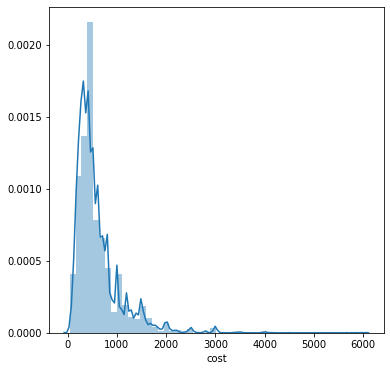

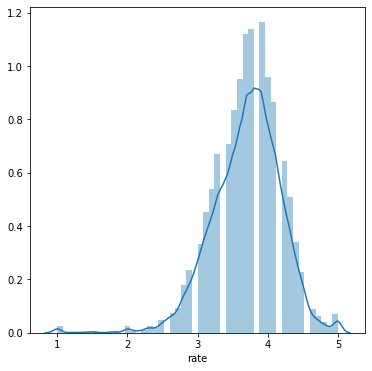

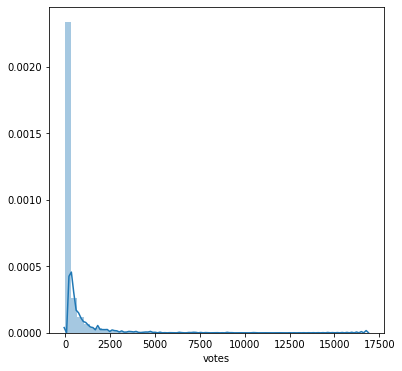

In [17]:
# Plot the distribution of numeric variables

for i, col in enumerate(num_data.columns):
    plt.figure(figsize=(6,6))
    sns.distplot(zomato_clean[col])
    plt.show()

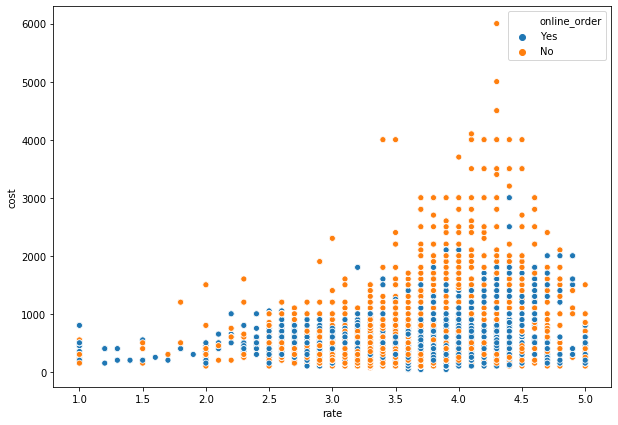

In [18]:
# Plot rate against cost color by online order

plt.figure(figsize=(10,7))
sns.scatterplot(x='rate', y='cost',hue='online_order',data=zomato_clean)
plt.show()

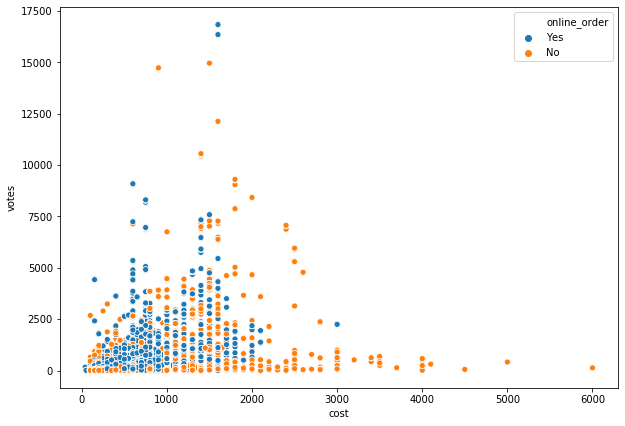

In [19]:
# Plot votes against cost color by online order

plt.figure(figsize=(10,7))
sns.scatterplot(x='cost', y='votes',hue='online_order',data=zomato_clean)
plt.show()

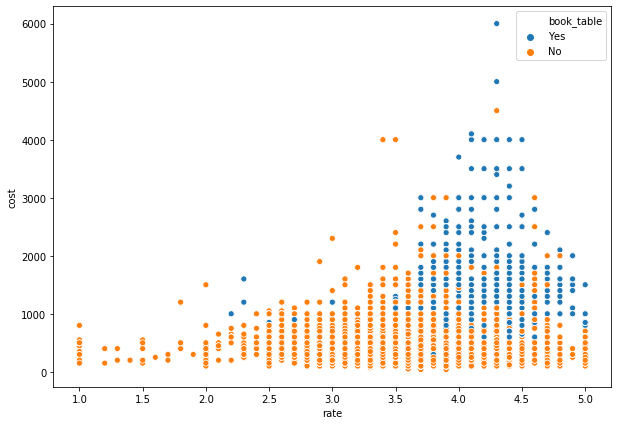

In [20]:
# Plot rate against cost color by book table

plt.figure(figsize=(10,7))
sns.scatterplot(x='rate', y='cost',hue='book_table',data=zomato_clean)
plt.show()

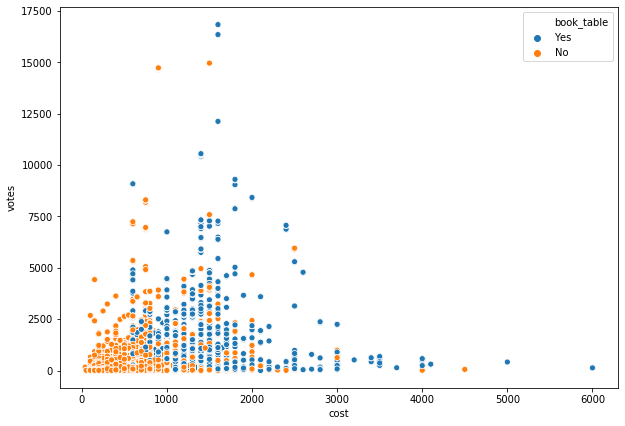

In [21]:
# Plot votes against cost color by book table

plt.figure(figsize=(10,7))
sns.scatterplot(x='cost', y='votes', hue='book_table',data=zomato_clean)
plt.show()

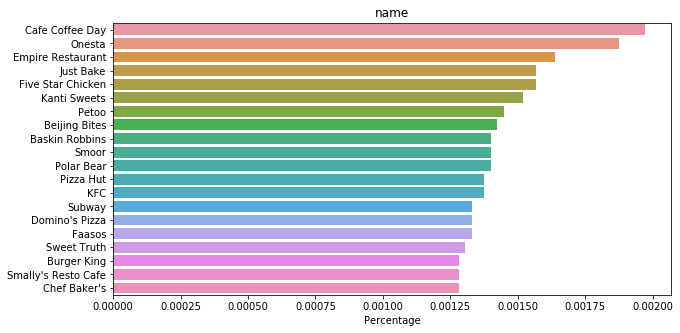

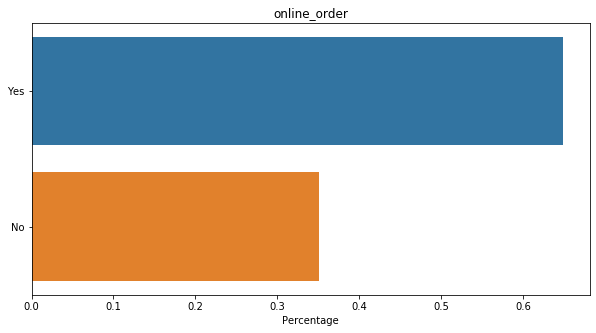

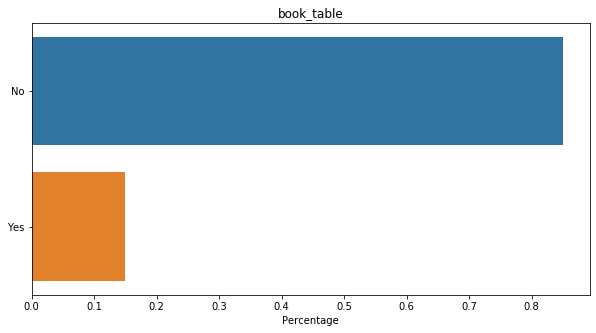

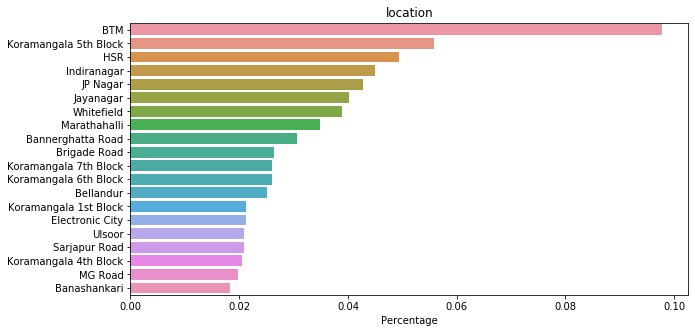

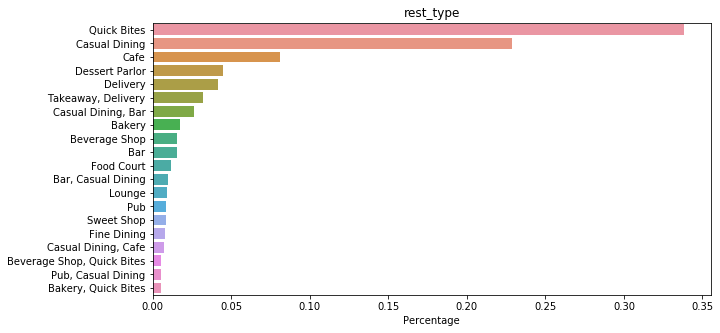

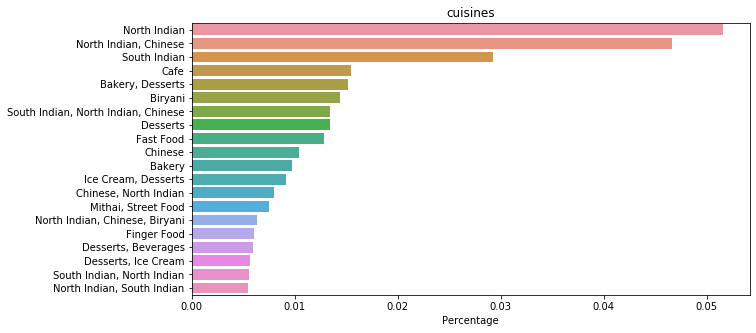

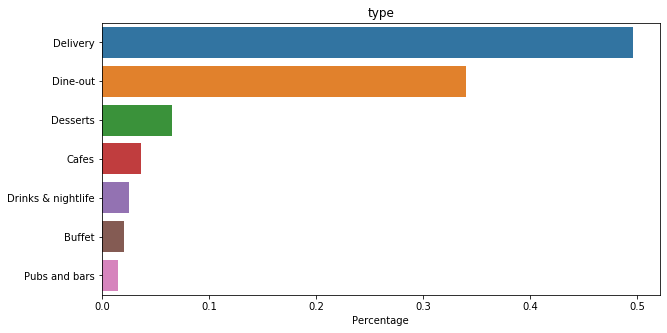

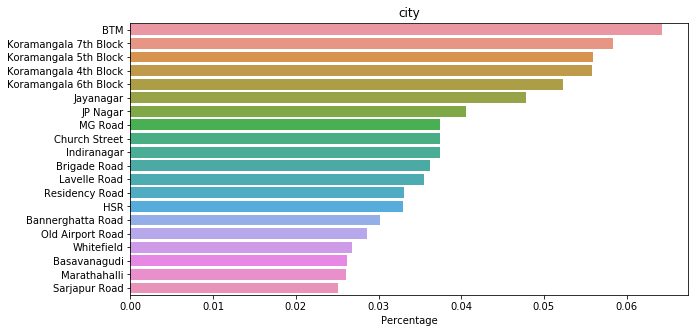

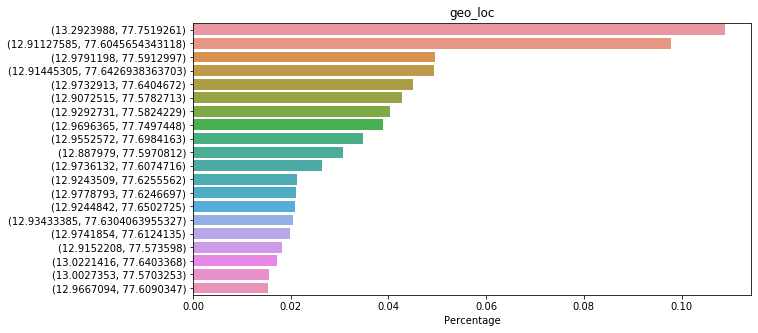

In [22]:
# Plot categorical variables

for i, col in enumerate(cat_data.columns):
    fig, ax = plt.subplots(figsize = (10, 5))
    top = pd.DataFrame(columns = cat_data.columns)
    top[col] = zomato_clean[col].value_counts(normalize=True)[:20]
    sns.barplot(top[col], top[col].index)
    plt.xlabel('Percentage')
    plt.title(col)

In [23]:
# Create database of restaurants grouped by location

import re

rest_locations = zomato_clean.groupby('location')['geo_loc'].value_counts().reset_index(name='locations').sort_values(by='locations', ascending=False)
rest_locations.columns = ['location', 'geo_loc', 'count']
rest_locations = rest_locations.reset_index().drop(columns='index')
rest_locations['geo_loc'] = rest_locations['geo_loc'].str.strip('()')

# Create two lists for the loop results to be placed

lat = []
lon = []

for row in rest_locations['geo_loc']:

    try:
        # Split the row by comma and append everything before the comma to lat
        lat.append(row.split(',')[0])
        # Split the row by comma and append everything after the comma to lon
        lon.append(row.split(',')[1])
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
rest_locations['lat'] = lat
rest_locations['lon'] = lon

rest_locations.head()

,location,geo_loc,count,lat,lon
0,BTM,"12.91127585, 77.6045654343118",4120,12.91127585,77.6045654343118
1,Koramangala 5th Block,"13.2923988, 77.7519261",2357,13.2923988,77.7519261
2,HSR,"12.91445305, 77.6426938363703",2079,12.91445305,77.6426938363703
3,Indiranagar,"12.9732913, 77.6404672",1895,12.9732913,77.6404672
4,JP Nagar,"12.9072515, 77.5782713",1805,12.9072515,77.5782713


In [24]:
# Define function to generate base map

def generateBaseMap(default_location=[12.97, 77.59], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [25]:
# Generate base map

from folium.plugins import HeatMap
import folium

basemap = generateBaseMap()
HeatMap(rest_locations[['lat','lon','count']].values.tolist(),zoom=20,radius=15).add_to(basemap)
basemap

In [26]:
# Define function to select data from clean dataframe, group by location and join with coordinates

def produce_data(col,name):
    data = pd.DataFrame(zomato_clean[zomato_clean[col]==name].groupby(['location'],as_index=False)['name'].agg('count'))
    data.columns=['location','count']
    data = data.merge(rest_locations, on='location', how='left').dropna()
    return data.drop(['geo_loc', 'count_y'],axis=1)

In [27]:
# Define function to generate map 

def produce_map(col, name):
    data = produce_data(col, name)
    basemap=generateBaseMap()
    HeatMap(data[['lat','lon','count_x']].values.tolist(),zoom=20,radius=15).add_to(basemap)
    return basemap

In [28]:
produce_data('cuisines', 'North Indian').head()

,location,count_x,lat,lon
0,BTM,270,12.91127585,77.6045654343118
1,Banashankari,31,12.9152208,77.573598
2,Banaswadi,5,13.0141618,77.6518539
3,Bannerghatta Road,57,12.887979,77.5970812
4,Basavanagudi,18,12.9417261,77.5755021


In [29]:
produce_map('cuisines', 'North Indian')

In [30]:
produce_map('cuisines', 'Cafe')

In [31]:
produce_map('rest_type', 'Quick Bites')

In [32]:
produce_map('name', 'Cafe Coffee Day')

In [33]:
produce_map('type', 'Delivery')

In [34]:
zomato_clean.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,type,city,geo_loc
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,Buffet,Banashankari,"(12.9152208, 77.573598)"
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,Buffet,Banashankari,"(12.9417261, 77.5755021)"


In [35]:
zomato_temp['dish_liked'] = zomato_temp['dish_liked'].apply(lambda x : x.split(',') if type(x)==str else [''])
zomato_temp['dish_liked'] 

0        [Pasta,  Lunch Buffet,  Masala Papad,  Paneer ...
1        [Momos,  Lunch Buffet,  Chocolate Nirvana,  Th...
2        [Churros,  Cannelloni,  Minestrone Soup,  Hot ...
3                                            [Masala Dosa]
4                                   [Panipuri,  Gol Gappe]
                               ...                        
51712                                                   []
51713                                                   []
51714                                                   []
51715                     [Cocktails,  Pizza,  Buttermilk]
51716                                                   []
Name: dish_liked, Length: 51717, dtype: object

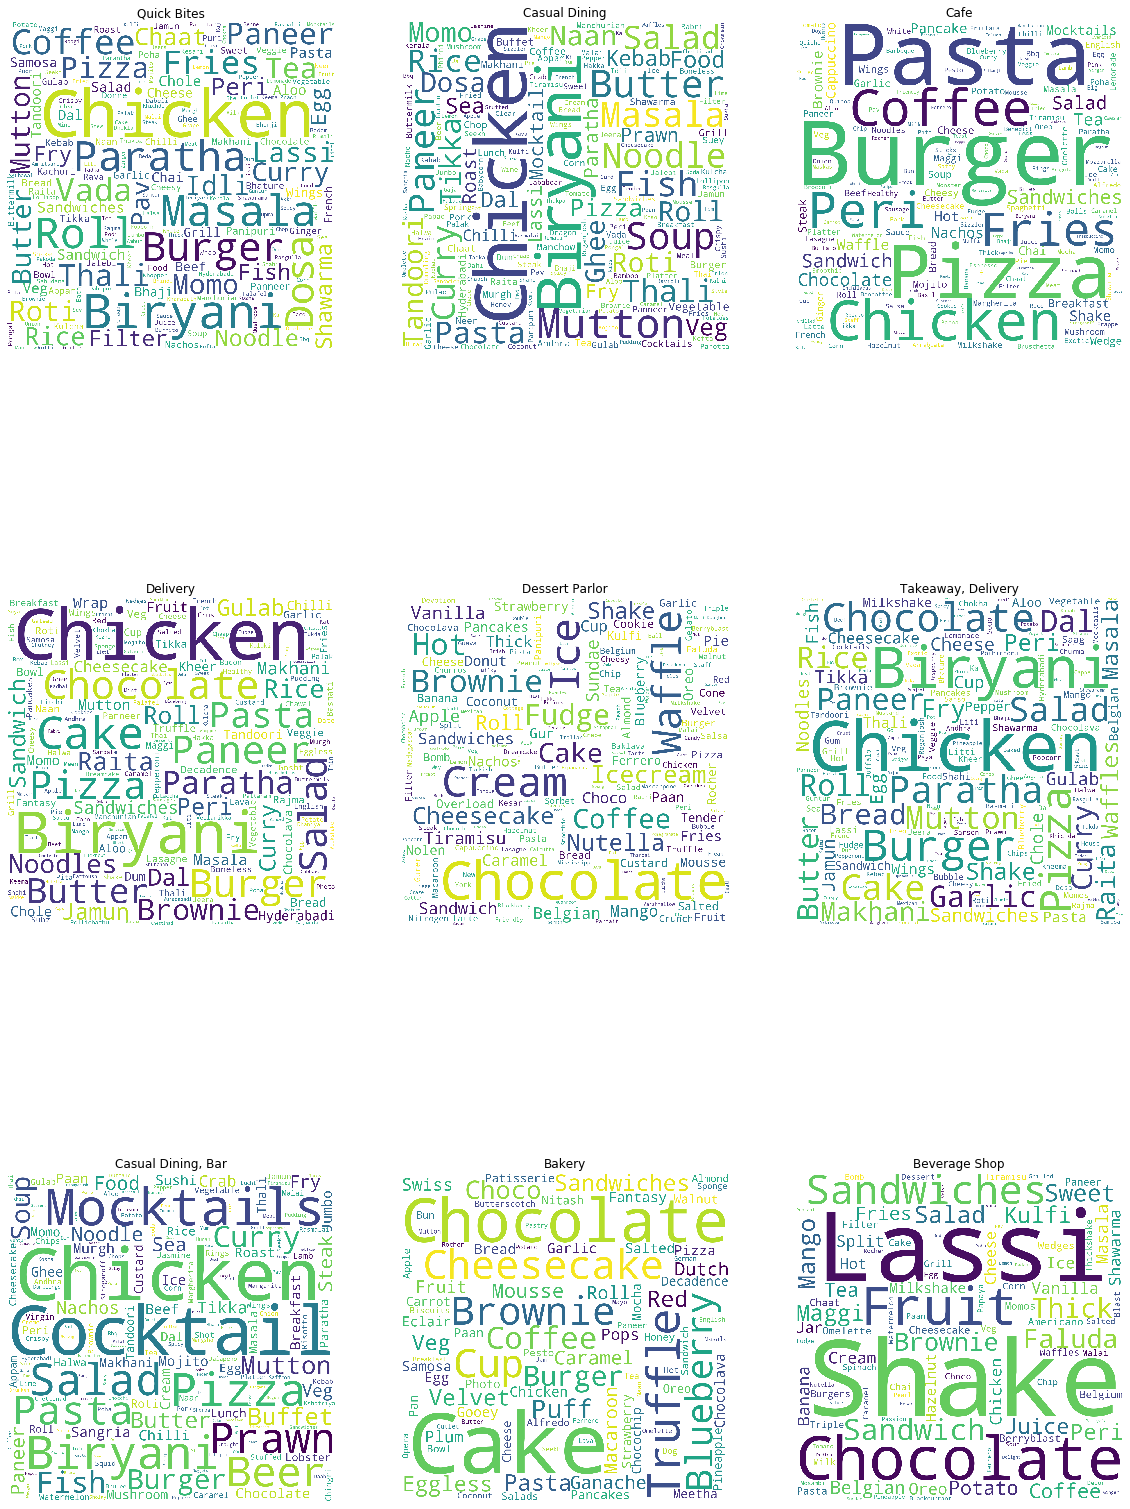

In [36]:
from wordcloud import WordCloud

rest = zomato_temp['rest_type'].value_counts()[:9].index

def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus = zomato_temp[zomato_temp['rest_type']==r]['dish_liked'].values.tolist()
        corpus=','.join(x  for list_words in corpus for x in list_words)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
           
produce_wordcloud(rest)

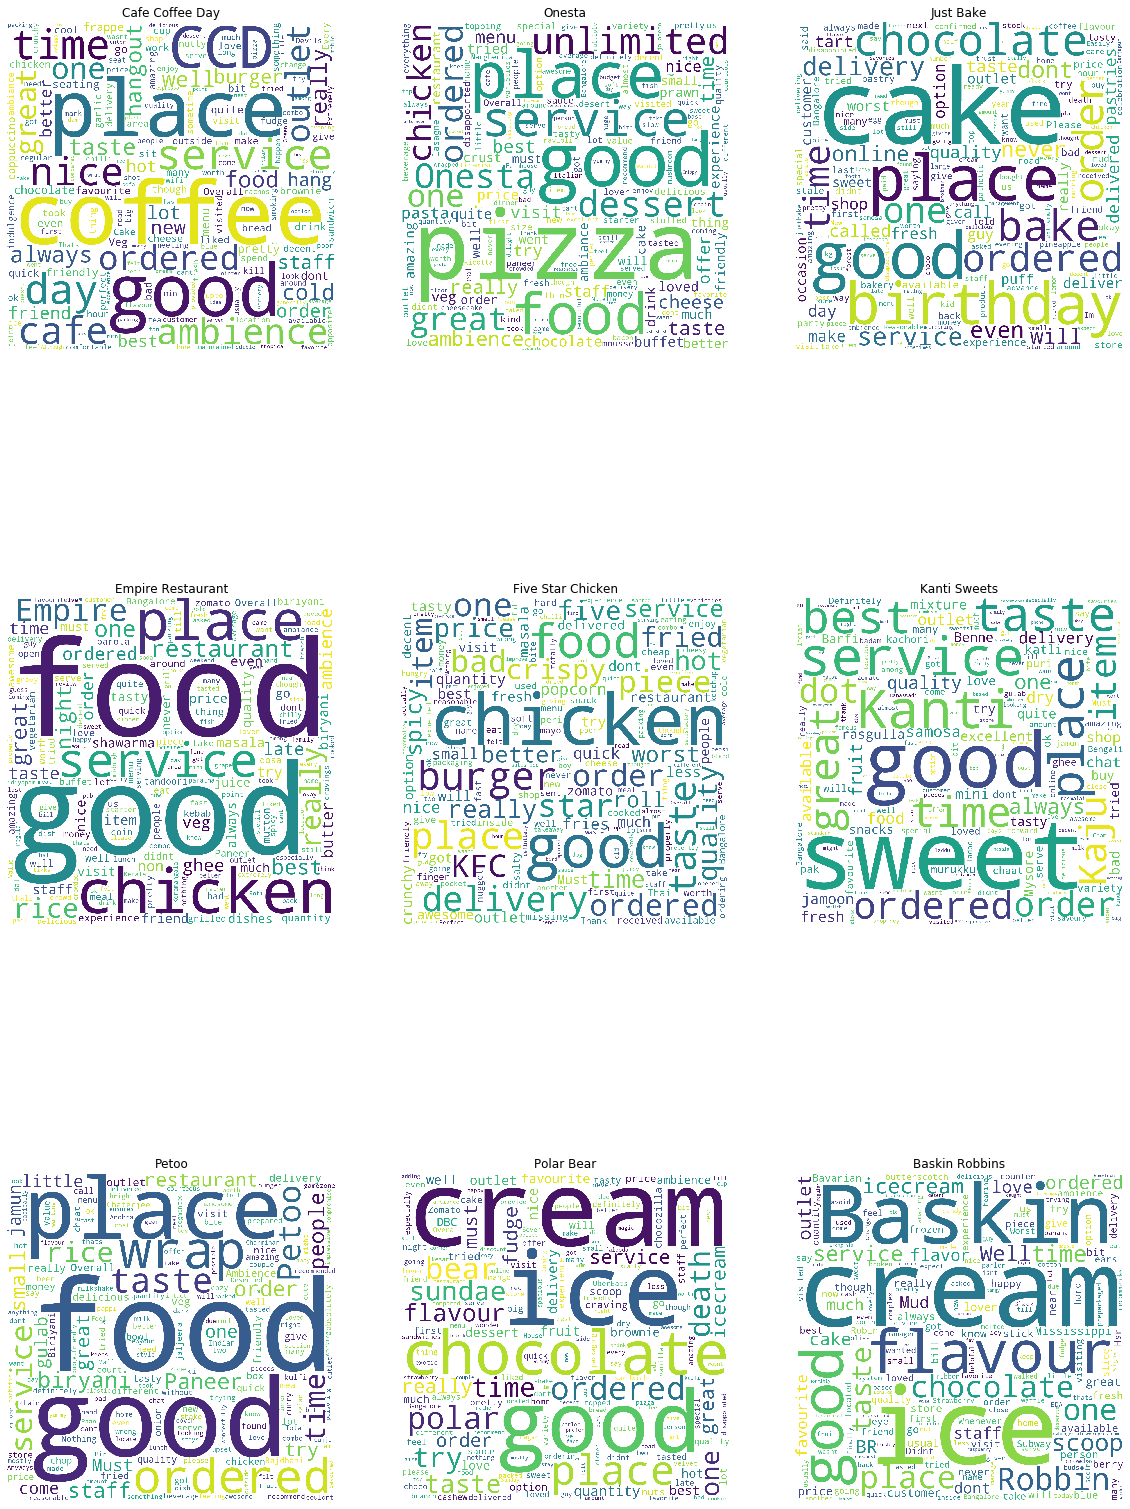

In [40]:
# Load dataset

ratings_df = pd.read_csv('ratings.csv', usecols=['name', 'rating', 'review'])
ratings_df.dropna(inplace=True)

rest = zomato_temp['name'].value_counts()[:9].index

def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus=ratings_df[ratings_df['name']==r]['review'].values.tolist()
        corpus=' '.join(x  for x in corpus)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        
produce_wordcloud(rest)